In [1]:
#Import modules
import sys
import re
import copy
import numpy as np
import pandas as pd
import random
import string
import pickle
from tqdm import tqdm

from Bio import Entrez
from Bio import Medline
import simple_icd_10_cm as cm

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from pprint import pprint
import datetime
import seaborn as sb
import altair as alt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import spacy

import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess #lemmatize, 
from gensim import models
from gensim.models import CoherenceModel, ldamodel
from gensim.test.utils import datapath
from gensim import corpora, models

import wordcloud
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harryreyesnieva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [113]:
df_abstracts = pd.read_csv('data/hdmh_abstracts.csv', index_col=False)
df_abstracts.head()

,PMID,Year,Article_Type,Language,Title,Abstract,MeSH,Dominant_Topic,Topic_Perc_Contrib,Topic_Name_No
0,24890184,2014,"['Journal Article', 'Research Support, N.I.H.,...",['eng'],"Sexual motivation, sexual transactions and sex...",Understanding the associations between sexual ...,"['Adult', '*Bisexuality', 'Condoms/*statistics...",10,0.9844,sexual health & behavior (10)
1,9314687,1997,['Journal Article'],['eng'],Insurance matters for low-income adults: resul...,"Using survey data from 2,000 low-income adult ...","['Adult', 'Eligibility Determination', 'Female...",16,0.9828,health insurance & utilization (16)
2,11475546,2001,['Journal Article'],['eng'],Gaps in health coverage among working-age Amer...,This paper examines health coverage and access...,"['Adolescent', 'Adult', 'Female', 'Health Bene...",16,0.9791,health insurance & utilization (16)
3,30518497,2019,"['Comparative Study', 'Journal Article']",['eng'],Demographic and facility volume related outcom...,BACKGROUND: To evaluate outcomes related to di...,"['Aged', 'Asians', 'Bilirubin/blood', 'Carcino...",15,0.9745,cancer treatment & outcomes (15)
4,30207901,2018,['Journal Article'],['eng'],Mexico's Seguro Popular: Achievements and Chal...,"In Mexico, Seguro Popular is a landmark govern...","['Achievement', 'Goals', '*Government Programs...",7,0.9694,health policy & government (7)


In [114]:
df_abstracts['Year'].value_counts()

Year
2020    13180
2019    13119
2018    12162
2017    11524
2015    11328
2016    11168
2014    10651
2013    10081
2012     9475
2011     8638
2010     8338
2009     7582
2008     7022
2007     6615
2006     5927
2005     5358
2004     4765
2003     4282
2002     3738
2001     3342
1998     3054
1999     3027
2000     2995
1997     2907
1996     2682
1995     2533
1994     2470
1993     2351
1992     2034
1991     1774
1990     1487
1989     1371
1988     1063
1986      931
1987      895
1984      884
1985      863
1983      679
1982      577
1979      530
1980      521
1981      501
1978      413
1975      408
1977      397
1976      369
Name: count, dtype: int64

In [3]:
#Register with Entrez
Entrez.email = '' #add email
Entrez.api_key='' #add api_key

# identify number of MEDLINE articles in English with abstracts and published between 1975 and 2020
# and print count by year

for year in range(1975, 2021):

    qry = [('english [la] AND has abstract[FILT] AND ("' + 
            str(year) + '/01/01"[Date - Publication] : "' + 
            str(year) + '/12/31"[Date - Publication])')]
    search_results = Entrez.read(
    Entrez.esearch(
        db="pubmed", term=qry, datetype="pdat", usehistory="n", 
        )
    )
    count = int(search_results["Count"])
    print("Found {} articles in MEDLINE in {}".format(count, year))

Found 82109 articles in MEDLINE in 1975
Found 90054 articles in MEDLINE in 1976
Found 88636 articles in MEDLINE in 1977
Found 93037 articles in MEDLINE in 1978
Found 101561 articles in MEDLINE in 1979
Found 110719 articles in MEDLINE in 1980
Found 112469 articles in MEDLINE in 1981
Found 121246 articles in MEDLINE in 1982
Found 149702 articles in MEDLINE in 1983
Found 164257 articles in MEDLINE in 1984
Found 172145 articles in MEDLINE in 1985
Found 179226 articles in MEDLINE in 1986
Found 189582 articles in MEDLINE in 1987
Found 199850 articles in MEDLINE in 1988
Found 228574 articles in MEDLINE in 1989
Found 238665 articles in MEDLINE in 1990
Found 249902 articles in MEDLINE in 1991
Found 260261 articles in MEDLINE in 1992
Found 268494 articles in MEDLINE in 1993
Found 280118 articles in MEDLINE in 1994
Found 290781 articles in MEDLINE in 1995
Found 301548 articles in MEDLINE in 1996
Found 309703 articles in MEDLINE in 1997
Found 326410 articles in MEDLINE in 1998
Found 339554 article

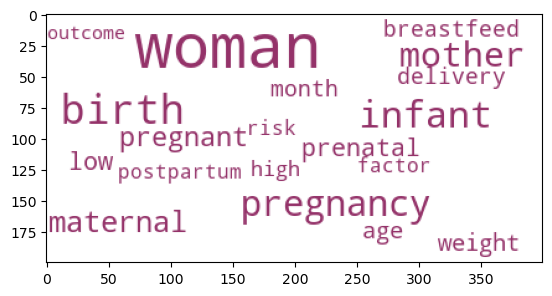

In [31]:
lda_model = models.LdaModel.load('models/lda_base_50.model')
plt.imshow(WordCloud(background_color='white',prefer_horizontal=1,max_font_size=50,color_func=
                     lambda *args, **kwargs: (148,50,105)).fit_words(dict(lda_model.show_topic(1, 19))))

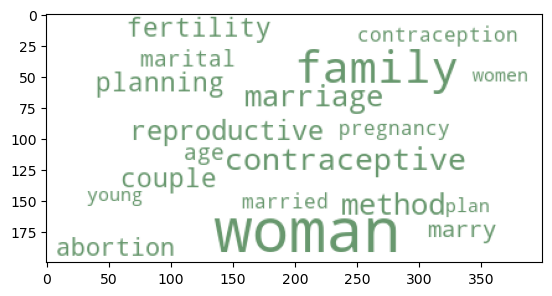

In [32]:
plt.imshow(WordCloud(background_color='white',prefer_horizontal=1,max_font_size=50,color_func=
                     lambda *args, **kwargs: (104,152,110)).fit_words(dict(lda_model.show_topic(2, 19))))

In [54]:
# MRCONSO.RRF is one of the files that comprise the UMLS MetaThesaurus. 
# The file is rather large (2.05 GB) and can be downloaded from:
# https://www.nlm.nih.gov/research/umls/licensedcontent/umlsknowledgesources.html

cols = ['CUI','LAT','TS','LUI','STT','SUI','ISPREF','AUI','SAUI','SCUI',
        'SDUI','SAB','','TTY','CODE','STR','SRL','SUPPRESS','CVF']
conso = pd.read_csv('data/MRCONSO.RRF', names = cols, sep='|', low_memory=False)
conso.head()

,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,,TTY,CODE,STR,SRL,SUPPRESS,CVF
0,C0000005,ENG,P,L0000005,PF,S0007492,Y,A26634265,NaN,M0019694,D012711,MSH,PEP,D012711,(131)I-Macroaggregated Albumin,0,N,256.0,NaN
1,C0000005,ENG,S,L0270109,PF,S0007491,Y,A26634266,NaN,M0019694,D012711,MSH,ET,D012711,(131)I-MAA,0,N,256.0,NaN
2,C0000005,FRE,P,L6220710,PF,S7133957,Y,A13433185,NaN,M0019694,D012711,MSHFRE,PEP,D012711,Macroagrégats d'albumine marquée à l'iode 131,3,N,NaN,NaN
3,C0000005,FRE,S,L6215648,PF,S7133916,Y,A27488794,NaN,M0019694,D012711,MSHFRE,ET,D012711,MAA-I 131,3,N,NaN,NaN
4,C0000005,FRE,S,L6215656,PF,S7133956,Y,A27614225,NaN,M0019694,D012711,MSHFRE,ET,D012711,Macroagrégats d'albumine humaine marquée à l'i...,3,N,NaN,NaN


In [116]:
conso_icd10cm = conso[conso['SAB'] == 'ICD10CM']
conso_icd10cm.head()

,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,,TTY,CODE,STR,SRL,SUPPRESS,CVF
5209,C0000727,ENG,P,L0000727,VCW,S0584932,N,A17803269,NaN,NaN,R10.0,ICD10CM,PT,R10.0,Acute abdomen,4,N,256.0,NaN
5210,C0000727,ENG,P,L0000727,VCW,S0584932,N,A20117915,NaN,NaN,R10.0,ICD10CM,AB,R10.0,Acute abdomen,4,Y,256.0,NaN
6110,C0000737,ENG,S,L9385397,PF,S11687982,N,A20162941,NaN,NaN,R10.9,ICD10CM,AB,R10.9,Unspecified abdominal pain,4,Y,256.0,NaN
6111,C0000737,ENG,S,L9385397,PF,S11687982,Y,A17867148,NaN,NaN,R10.9,ICD10CM,PT,R10.9,Unspecified abdominal pain,4,N,256.0,NaN
6533,C0000744,ENG,P,L0000744,PF,S0009088,N,A17774174,NaN,NaN,E78.6,ICD10CM,ET,E78.6,Abetalipoproteinemia,4,N,256.0,NaN


In [121]:
batch_icd = []
with open("data/text.out") as f: 
    for line in f.readlines():
        li=line.strip('\n')
        if not line.startswith('>>>>> MMI') and not li.startswith('<<<<< MMI'):
            batch_icd.append(li.split("|"))

df_icd = pd.DataFrame(batch_icd, columns=['PMID','MM','Score','Preferred_Name','CUI','Semantic_Type','Trigger_Info','Location','Pos_Info','Treecode'])
df_icd.head()

,PMID,MM,Score,Preferred_Name,CUI,Semantic_Type,Trigger_Info,Location,Pos_Info,Treecode
0,35704653,AA,NHPI,Native Hawaiians/Pacific Islander,1,4,7,33,197:4,None
1,35704653,AA,NHPIs,Native Hawaiians/Pacific Islanders,1,5,7,34,218:5,None
2,35704653,AA,QDR,Quality and Disparities Report,1,3,7,30,337:3,None
3,35679440,AA,QDR,Quality and Disparities Reports,1,3,7,31,251:3,None
4,35679440,MMI,116.77,Weakness,C3714552,[sosy],"[""Weakness""-ti-4-""weaknesses""-noun-0]",TI,701/10,


In [99]:
df_icdconso = pd.merge(df_icd[['PMID','CUI']], conso_icd10cm[['CUI','SAB','TTY','CODE',]], how='inner', on='CUI').drop_duplicates()
df_icdconso['PMID'] = df_icdconso['PMID'].str.replace('"', '')
df_icdconso['TTY'] = df_icdconso['TTY'].astype(str)
df_icdconso.sort_values(by='PMID')
df_icdconso.head()

,PMID,CUI,SAB,TTY,CODE
0,35679440,C3714552,ICD10CM,R53.1,Weakness
2,35679440,C3714552,ICD10CM,R53.81,Debility NOS
3,33615310,C3714552,ICD10CM,R53.1,Weakness
5,33615310,C3714552,ICD10CM,R53.81,Debility NOS
6,33527901,C3714552,ICD10CM,R53.1,Weakness


In [100]:
test = cm.get_ancestors(df_icdconso['TTY'][0])
print(test)
last_element = test.pop()
print(last_element)

['R53', 'R50-R69', '18']
18


In [101]:
valid_item = lambda x: cm.is_valid_item(x)
df_icdconso['ICD_valid'] = df_icdconso['TTY'].apply(valid_item)
df_icdconso[df_icdconso['ICD_valid'] == False].TTY.unique()

array(['C50-C50', 'F99-F99', 'G00-G99', 'J00-J99', 'B99-B99', 'I00-I99',
       'Z17-Z17', 'F01-F99'], dtype=object)

In [102]:
df_icdconso["TTY"].replace({"F99-F99": "F98",
                            "C50-C50": "C50",
                            "G00-G99": "G00",
                            "J00-J99": "J00",
                            "Z17-Z17": "Z17",
                            "I00-I99": "I00",
                            "B99-B99": "B99",
                            "B20-B20": "B20",
                            "N00-N99": "N00",
                            "Z66-Z66": "Z66",
                            "F01-F99": "F01"}, inplace=True)

In [103]:
df_icdconso['ICD_valid'] = df_icdconso['TTY'].apply(valid_item)

In [115]:
chp = lambda x: cm.get_ancestors(x).pop()
df_icdconso['ICD_Chapter'] = df_icdconso['TTY'].apply(chp)
df_icdconso.head()

,PMID,CUI,SAB,TTY,CODE,ICD_valid,ICD_Chapter
0,35679440,C3714552,ICD10CM,R53.1,Weakness,True,18
2,35679440,C3714552,ICD10CM,R53.81,Debility NOS,True,18
3,33615310,C3714552,ICD10CM,R53.1,Weakness,True,18
5,33615310,C3714552,ICD10CM,R53.81,Debility NOS,True,18
6,33527901,C3714552,ICD10CM,R53.1,Weakness,True,18


In [106]:
df_icdconso_uchp = df_icdconso.drop_duplicates(subset=['PMID','ICD_Chapter'])
icd_chp_tbl = df_icdconso_uchp['ICD_Chapter'].value_counts().to_frame('Counts')
icd_chp_tbl['Percentage'] = round((icd_chp_tbl['Counts'] / len(df_icdconso.drop_duplicates(subset=['PMID'])))*100)
icd_chp_tbl.reset_index(inplace=True)
icd_chp_tbl['ICD_Chapter'] = icd_chp_tbl['ICD_Chapter'].astype('int')
icd_chp_tbl.sort_values(by=['ICD_Chapter'])

,ICD_Chapter,Counts,Percentage
7,1,17613,11.0
2,2,28250,17.0
5,3,24429,15.0
3,4,26513,16.0
4,5,25956,16.0
13,6,4403,3.0
16,7,2701,2.0
20,8,1086,1.0
9,9,13868,8.0
11,10,6886,4.0


In [107]:
# these are based on the same query parameters used to identify HDMH articles

black_tiab_list = ['Black American','Black Americans','African American','African Americans','African ancestry']
black_mh_list = ['African Continental Ancestry Group','African Americans']

asian_tiab_list = ['Asian','Asians']
asian_mh_list = ['Asian Continental Ancestry Group','Asian Americans']

latino_tiab_list = ['Hispanic','Hispanics','Latina','Latinas','Latino','Latinos']
latino_mh_list = ['Hispanic Americans','Mexican Americans']

naan_tiab_list = ['AIAN','Alaska Native','Alaska Natives','Native American','Native Americans']
naan_mh_list = ['American Native Continental Ancestry Group','Indians, Central American','Indians, North American',
                  'Alaskan Natives','Indigenous Canadians','Inuits','American Natives','Indians, South American']

nhpi_tiab_list = ['Native Hawaiian','Native Hawaiians','Pacific Islander','Pacific Islanders']
nhpi_mh_list = ['Oceanic Ancestry Group']

immigrant_tiab_list = ['migrant worker','migrant workers','immigrant','immigrants','refugees']
immigrant_mh_list = ['Refugees','Transients and Migrants','Undocumented Immigrants']

lgbtq_tiab_list = ['bisexuals','bisexual','bigender','disorders of sex development','female homosexuality',
                   'gay','gays','gender change','gender confirmation','gender disorder','gender disorders',
                   'gender dysphoria','gender diverse','gender-diverse','gender diversity','gender identity',
                   'gender minorities','gender non conforming','gender non-conforming','gender orientation',
                   'genderqueer','gender reassignment','gender surgery','GLBT','GLBTQ','homophile','homophilia',
                   'homosexual','homosexuals','intersex','lesbian','lesbianism','lesbians','LGBBTQ','LGBT',
                   'LGBTI','LGBTQ','LGBTQI','LGBTQIA','men who have sex with men','men having sex with men',
                   'men who have sex with other men','nonheterosexual','non-heterosexual','non heterosexuals',
                   'nonheterosexuals','pansexual','polysexual','same sex ','sex change','sex reassignment',
                   'sex reassignment surgery','sexual diversity','sexual minorities','sexual minority',
                   'sexual orientation','transgender','transsexual','transgender*','transsexual*','transman','trans men','transmen',
                   'transsexualism','transwoman','trans women','transwomen','two spirit','two-spirit',
                   'women who have sex with women']

lgbtq_mh_list = ['Disorders of Sex Development','Gender Identity',
                 'Health Services for Transgender Persons','Homosexuality',
                 'Homosexuality, Female','Homosexuality, Male',
                 'Sexual and Gender Disorders','Sexual and Gender Minorities',
                 'Sex reassignment procedures','Sex Reassignment Surgery',
                 'Transsexualism','Transgender Persons']

disability_tiab_list = ['disabled','disabled persons']
disability_mh_list = ['Disabled Persons']

urban_tiab_list = ['urban population','urban populations','slum','slums','ghetto','ghettos']
urban_mh_list = ['Urban Health','Urban Health Services','Urban Population']

rural_tiab_list = ['rural health','rural population','rural populations']
rural_mh_list = ['Rural Health','Rural Health Services','Rural Population']

In [109]:
df_abstracts_icd.loc[:, 'black_tiab'] = df_abstracts_icd['Title_Abstract'].str.contains('|'.join(black_tiab_list)).astype(int)
df_abstracts_icd.loc[:, 'black_mh'] = df_abstracts_icd['MeSH'].str.contains('|'.join(black_mh_list)).astype(int)

df_abstracts_icd.loc[:, 'asian_tiab'] = df_abstracts_icd['Title_Abstract'].str.contains('|'.join(asian_tiab_list)).astype(int)
df_abstracts_icd.loc[:, 'asian_mh'] = df_abstracts_icd['MeSH'].str.contains('|'.join(asian_mh_list)).astype(int)

df_abstracts_icd.loc[:, 'latino_tiab'] = df_abstracts_icd['Title_Abstract'].str.contains('|'.join(latino_tiab_list)).astype(int)
df_abstracts_icd.loc[:, 'latino_mh'] = df_abstracts_icd['MeSH'].str.contains('|'.join(latino_mh_list)).astype(int)

df_abstracts_icd.loc[:, 'naan_tiab'] = df_abstracts_icd['Title_Abstract'].str.contains('|'.join(naan_tiab_list)).astype(int)
df_abstracts_icd.loc[:, 'naan_mh'] = df_abstracts_icd['MeSH'].str.contains('|'.join(naan_mh_list)).astype(int)

df_abstracts_icd.loc[:, 'nhpi_tiab'] = df_abstracts_icd['Title_Abstract'].str.contains('|'.join(nhpi_tiab_list)).astype(int)
df_abstracts_icd.loc[:, 'nhpi_mh'] = df_abstracts_icd['MeSH'].str.contains('|'.join(nhpi_mh_list)).astype(int)

df_abstracts_icd.loc[:, 'immigrant_tiab'] = df_abstracts_icd['Title_Abstract'].str.contains('|'.join(immigrant_tiab_list)).astype(int)
df_abstracts_icd.loc[:, 'immigrant_mh'] = df_abstracts_icd['MeSH'].str.contains('|'.join(immigrant_mh_list)).astype(int)

df_abstracts_icd.loc[:, 'lgbtq_tiab'] = df_abstracts_icd['Title_Abstract'].str.contains('|'.join(lgbtq_tiab_list)).astype(int)
df_abstracts_icd.loc[:, 'lgbtq_mh'] = df_abstracts_icd['MeSH'].str.contains('|'.join(lgbtq_mh_list)).astype(int)

df_abstracts_icd.loc[:, 'disability_tiab'] = df_abstracts_icd['Title_Abstract'].str.contains('|'.join(disability_tiab_list)).astype(int)
df_abstracts_icd.loc[:, 'disability_mh'] = df_abstracts_icd['MeSH'].str.contains('|'.join(disability_mh_list)).astype(int)

df_abstracts_icd.loc[:, 'urban_tiab'] = df_abstracts_icd['Title_Abstract'].str.contains('|'.join(urban_tiab_list)).astype(int)
df_abstracts_icd.loc[:, 'urban_mh'] = df_abstracts_icd['MeSH'].str.contains('|'.join(urban_mh_list)).astype(int)

df_abstracts_icd.loc[:, 'rural_tiab'] = df_abstracts_icd['Title_Abstract'].str.contains('|'.join(rural_tiab_list)).astype(int)
df_abstracts_icd.loc[:, 'rural_mh'] = df_abstracts_icd['MeSH'].str.contains('|'.join(rural_mh_list)).astype(int)

In [108]:
df_abstracts['PMID'] = df_abstracts['PMID'].astype('str')
df_icdconso['PMID'] = df_icdconso['PMID'].astype('str')
df_abstracts_icd = df_abstracts[['PMID','Title','Abstract','MeSH']].merge(
    df_icdconso[['PMID','ICD_Chapter','TTY']], how='left', on='PMID')
df_abstracts_icd['Title_Abstract'] = df_abstracts_icd['Title'] + df_abstracts_icd['Abstract']
df_abstracts_icd['Title_Abstract'] = df_abstracts_icd['Title_Abstract'].str.replace('|', ' ')
df_abstracts_icd.head()

,PMID,Title,Abstract,MeSH,ICD_Chapter,TTY,Title_Abstract
0,24890184,"Sexual motivation, sexual transactions and sex...",Understanding the associations between sexual ...,"['Adult', '*Bisexuality', 'Condoms/*statistics...",1,A64,"Sexual motivation, sexual transactions and sex..."
1,24890184,"Sexual motivation, sexual transactions and sex...",Understanding the associations between sexual ...,"['Adult', '*Bisexuality', 'Condoms/*statistics...",1,A50-A64,"Sexual motivation, sexual transactions and sex..."
2,24890184,"Sexual motivation, sexual transactions and sex...",Understanding the associations between sexual ...,"['Adult', '*Bisexuality', 'Condoms/*statistics...",4,E50.8,"Sexual motivation, sexual transactions and sex..."
3,9314687,Insurance matters for low-income adults: resul...,"Using survey data from 2,000 low-income adult ...","['Adult', 'Eligibility Determination', 'Female...",21,Z59.6,Insurance matters for low-income adults: resul...
4,11475546,Gaps in health coverage among working-age Amer...,This paper examines health coverage and access...,"['Adolescent', 'Adult', 'Female', 'Health Bene...",NaN,NaN,Gaps in health coverage among working-age Amer...


In [117]:
df_abstracts_icd["Black"] = df_abstracts_icd[["black_tiab", "black_mh"]].max(axis=1)
df_abstracts_icd["Asian"] = df_abstracts_icd[["asian_tiab", "asian_mh"]].max(axis=1)
df_abstracts_icd["Latino"] = df_abstracts_icd[["latino_tiab", "latino_mh"]].max(axis=1)
df_abstracts_icd["NAAN"] = df_abstracts_icd[["naan_tiab", "naan_mh"]].max(axis=1)
df_abstracts_icd["NHPI"] = df_abstracts_icd[["nhpi_tiab", "nhpi_mh"]].max(axis=1)
df_abstracts_icd["Immigrant"] = df_abstracts_icd[["immigrant_tiab", "immigrant_mh"]].max(axis=1)
df_abstracts_icd["SGM"] = df_abstracts_icd[["lgbtq_tiab", "lgbtq_mh"]].max(axis=1)
df_abstracts_icd["Disabled"] = df_abstracts_icd[["disability_tiab", "disability_mh"]].max(axis=1)
df_abstracts_icd["Urban"] = df_abstracts_icd[["urban_tiab", "urban_mh"]].max(axis=1)
df_abstracts_icd["Rural"] = df_abstracts_icd[["rural_tiab", "rural_mh"]].max(axis=1)
df_abstracts_icd.head()

,PMID,Title,Abstract,MeSH,ICD_Chapter,TTY,Title_Abstract,black_tiab,black_mh,asian_tiab,...,Black,Asian,Latino,NAAN,NHPI,Immigrant,SGM,Disabled,Urban,Rural
0,24890184,"Sexual motivation, sexual transactions and sex...",Understanding the associations between sexual ...,"['Adult', '*Bisexuality', 'Condoms/*statistics...",1,A64,"Sexual motivation, sexual transactions and sex...",0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,24890184,"Sexual motivation, sexual transactions and sex...",Understanding the associations between sexual ...,"['Adult', '*Bisexuality', 'Condoms/*statistics...",1,A50-A64,"Sexual motivation, sexual transactions and sex...",0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,24890184,"Sexual motivation, sexual transactions and sex...",Understanding the associations between sexual ...,"['Adult', '*Bisexuality', 'Condoms/*statistics...",4,E50.8,"Sexual motivation, sexual transactions and sex...",0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,9314687,Insurance matters for low-income adults: resul...,"Using survey data from 2,000 low-income adult ...","['Adult', 'Eligibility Determination', 'Female...",21,Z59.6,Insurance matters for low-income adults: resul...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11475546,Gaps in health coverage among working-age Amer...,This paper examines health coverage and access...,"['Adolescent', 'Adult', 'Female', 'Health Bene...",NaN,NaN,Gaps in health coverage among working-age Amer...,0,0,0,...,0,0,0,0,0,0,0,0,0,0


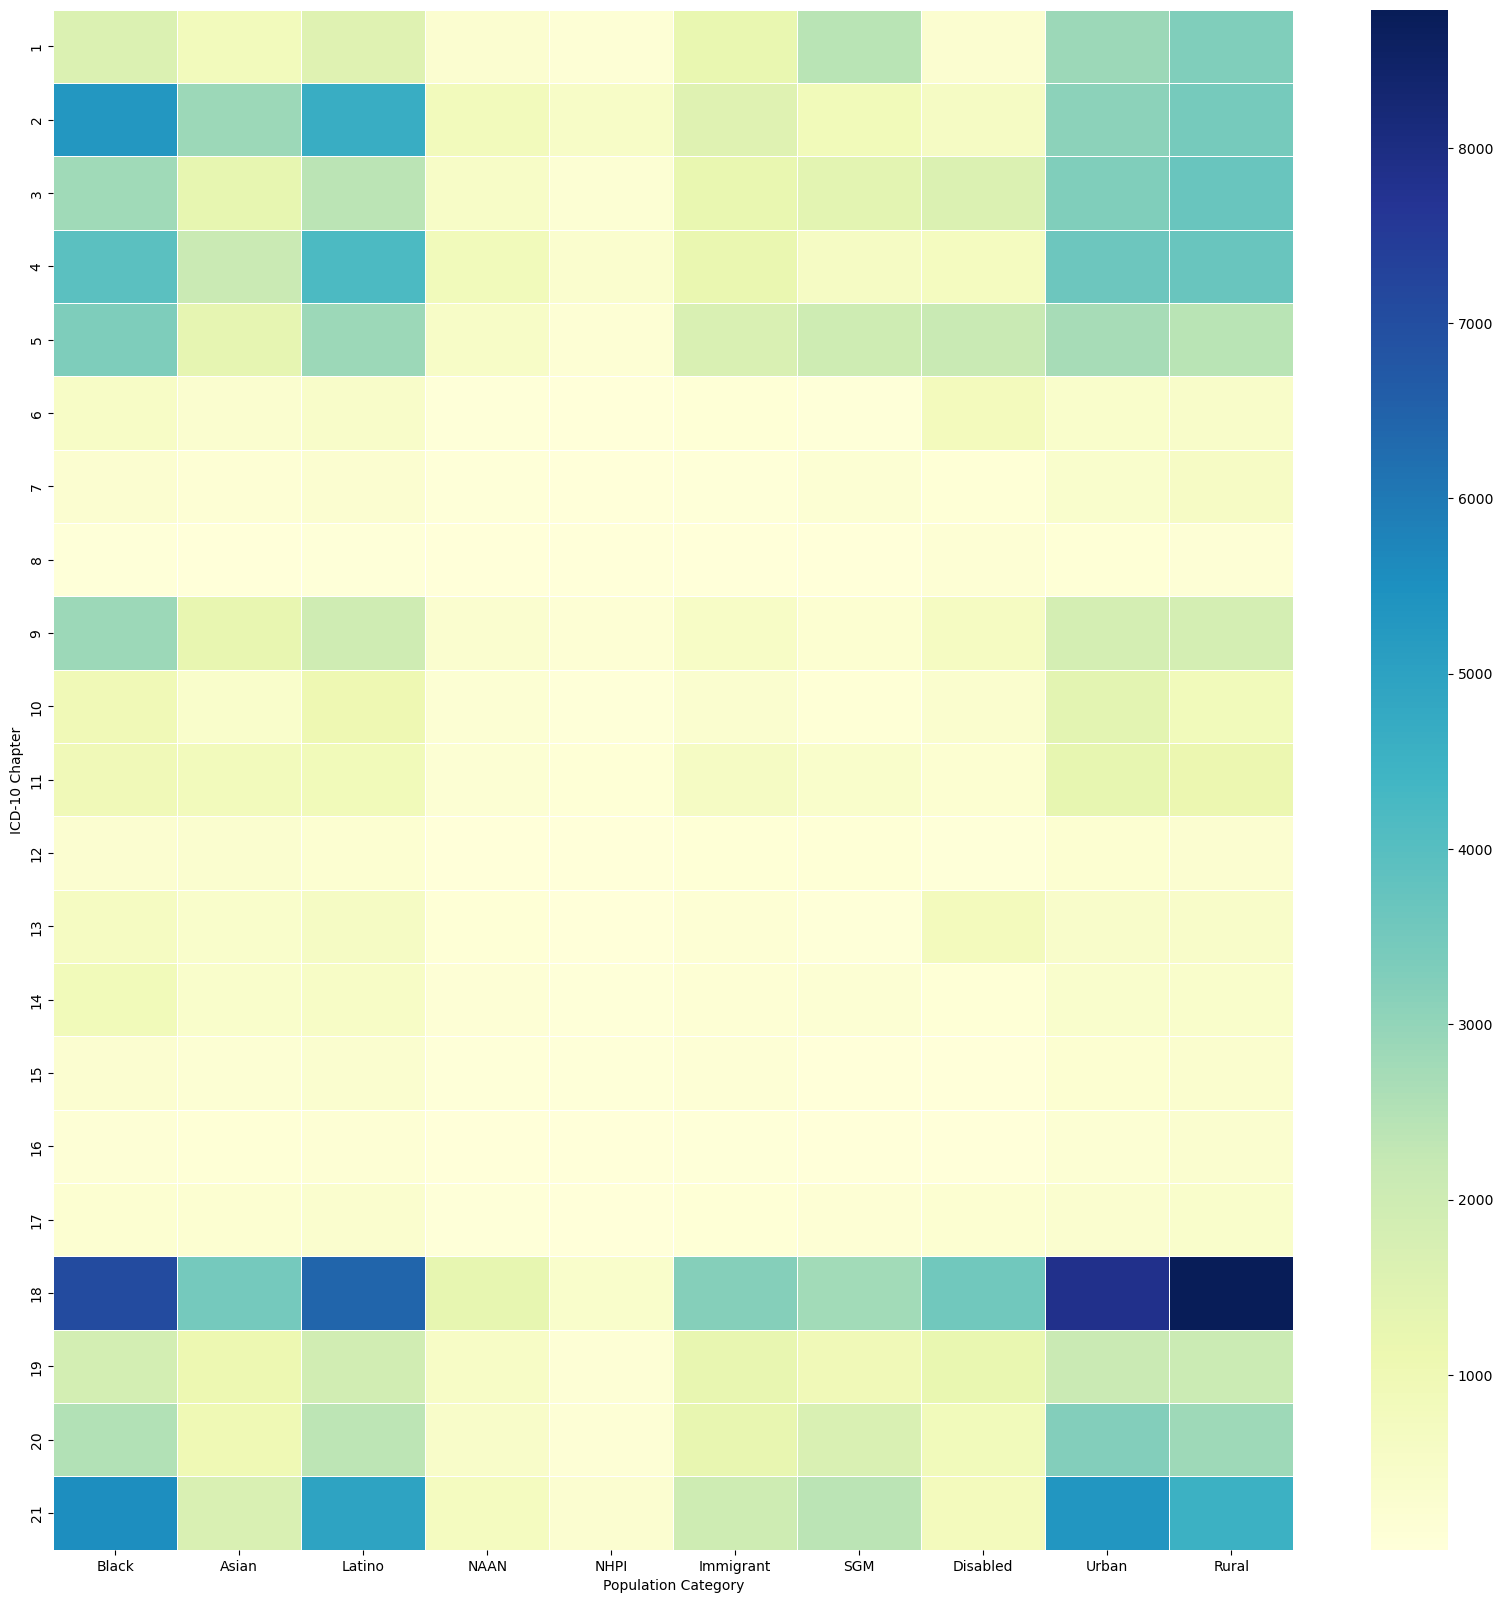

In [118]:
#HDMH Article Counts by ICD-10 Chapter and Population Category

df_heat = df_abstracts_icd[['PMID','ICD_Chapter','Black', 'Asian','Latino','NAAN','NHPI',
                                'Immigrant','SGM', 'Disabled', 'Urban', 'Rural']].dropna()
df_heat = df_heat.drop_duplicates()
heat = df_heat.loc[:,['ICD_Chapter','Black', 'Asian','Latino','NAAN','NHPI',
                      'Immigrant','SGM', 'Disabled', 'Urban', 'Rural' ]]
heat['ICD_Chapter'] = heat['ICD_Chapter'].dropna().astype('int')
heat = heat[(heat['ICD_Chapter'] < 22)]

heatm = heat.groupby(["ICD_Chapter"]).sum()

fig, ax = plt.subplots(figsize=(20, 20))
sns_plot = sb.heatmap(heatm, linewidths=.5, cmap="YlGnBu")
ax.set(ylabel='ICD-10 Chapter', xlabel='Population Category')
plt.show()
sns_plot.figure.savefig("dryad/icd_mesh.png", transparent=True)

In [16]:
df_abstracts[['Topic_Name_No']].value_counts(normalize=True) * 100

Topic_Name_No                         
community-based research (1)              6.504507
economic policy (2)                       6.471014
race, ethnicity, SES (3)                  5.354083
access to care & services (4)             4.859449
population trends (5)                     4.214338
disease prevalence (6)                    3.106630
health policy & government (7)            3.093039
adolescents & youth (8)                   3.078476
beliefs & culture (9)                     3.011975
sexual health & behavior (10)             2.881400
maternal-child health (11)                2.860041
cultural competence (12)                  2.824606
overweight & obesity (13)                 2.793055
survey-based studies (14)                 2.753736
cancer treatment & outcomes (15)          2.741601
health insurance & utilization (16)       2.657140
mental health (17)                        2.574134
knowledge, attitudes, perceptions (18)    2.500837
diabetes & cardiovascular disease (19)    2

In [15]:
source = df_abstracts[['Topic_Name_No']].value_counts(normalize=True).rename_axis('Topic').reset_index(name='Percentage')

alt.Chart(source).mark_bar(size=19, color='#D2D2C0').encode(
   x=alt.X('Percentage:Q', axis=alt.Axis(format='%', title = 'Percentage of HDMH articles',titleFont="Avenir")),
   y=alt.Y('Topic:N', axis=alt.Axis(title = 'Topic', titleFont="Avenir" ), sort=None)).configure_axis(
    labelFont="Avenir", titleFont="Avenir")

alt.Chart(...)

In [33]:
num = df_abstracts[["Year","Dominant_Topic", "Topic_Name_No",]].value_counts().reset_index(name='Numerator')
num['Year'] = source.Year.astype(str)
denom = df_abstracts[["Year"]].value_counts().reset_index(name='Denominator')
denom['Year'] = denom.Year.astype(str)
perc = pd.merge(num, denom, how='left', on=['Year'])
perc['Percentage'] = perc['Numerator'] / source2['Denominator'] 
perc['Percentage'] = perc.Percentage.astype(float)
pivot = perc.pivot_table(values="Numerator", index="Topic_Name_No", columns="Year").stack(dropna=False).reset_index()
source = pd.merge(pivot[['Topic_Name_No','Year' ]], perc, how='left', on=['Topic_Name_No','Year'])
source = source.fillna(0)
source

,Topic_Name_No,Year,Dominant_Topic,Numerator,Denominator,Percentage
0,access to care & services (4),1975,4.0,7.0,408.0,0.017157
1,access to care & services (4),1976,4.0,5.0,369.0,0.013550
2,access to care & services (4),1977,4.0,8.0,397.0,0.020151
3,access to care & services (4),1978,4.0,6.0,413.0,0.014528
4,access to care & services (4),1979,4.0,4.0,530.0,0.007547
...,...,...,...,...,...,...
2295,urban-rural status (41),2016,41.0,79.0,11168.0,0.007074
2296,urban-rural status (41),2017,41.0,84.0,11524.0,0.007289
2297,urban-rural status (41),2018,41.0,99.0,12162.0,0.008140
2298,urban-rural status (41),2019,41.0,108.0,13119.0,0.008232


In [44]:
list1 = ['cancer screening (27)','cancer treatment & outcomes (15)',
         'cancer incidence & mortality (38)',
         'genetics and epigenetics (23)','environmental health (45)', ]

list2 = ['maternal-child health (11)','reproductive health (33)',
         'sexual & gender minorities (42)','sexual health & behavior (10)',
         'household environment (31)',]

list3 = ['child development (21)','adolescents & youth (8)','immigrant health (43)',
         'urban-rural status (41)','race, ethnicity, neighborhood (29)',]

list4 = ['access to care & services (4)','race, ethnicity, SES (3)','healthcare costs (35)', 
         'health policy & government (7)','health insurance & utilization (16)',]

list5 = ['economic policy (2)','population trends (5)', 'disease prevalence (6)',
         'diagnosis & treatment delay (34)', 'medical education (25)','race, ethnicity, education (36)',]

list6 = ['community-based research (1)','cultural competence (12)',
         'beliefs & culture (9)','knowledge, attitudes, perceptions (18)', 
         'communication & decision-making (28)','survey-based studies (14)',]

list7 = ['overweight & obesity (13)','diabetes & cardiovascular disease (19)', 
         'diet & nutrition (24)','physical activity & disability (30)', 
         'medications (22)',]
   
list8 = ['mental health (17)', 'tobacco use & cessation (37)',
         'substance use & criminalization (44)','mortality, injury, suicide (39)',
         'sleep & stress (49)',]

list9 = ['global health (48)', 'infectious diseases (26)','patient satisfaction (46)',
         'primary & specialist care (20)','hospital-based care (32)', 'oral health (40)',]

dft1_list1 = source.Topic_Name_No.isin(list1)
dft_list1 = source[dft1_list1]

dft1_list2 = source.Topic_Name_No.isin(list2)
dft_list2 = source[dft1_list2]

dft1_list3 = source.Topic_Name_No.isin(list3)
dft_list3 = source[dft1_list3]

dft1_list4 = source.Topic_Name_No.isin(list4)
dft_list4 = source[dft1_list4]

dft1_list5 = source.Topic_Name_No.isin(list5)
dft_list5 = source[dft1_list5]

dft1_list6 = source.Topic_Name_No.isin(list6)
dft_list6 = source[dft1_list6]

dft1_list7 = source.Topic_Name_No.isin(list7)
dft_list7 = source[dft1_list7]

dft1_list8 = source.Topic_Name_No.isin(list8)
dft_list8 = source[dft1_list8]

dft1_list9 = source.Topic_Name_No.isin(list9)
dft_list9 = source[dft1_list9]

In [45]:
dftp_list1 = dft_list1.pivot_table(index=['Dominant_Topic','Year'],columns='Topic_Name_No', values='Percentage')
dftp_list1.reset_index(inplace=True)

base = alt.Chart(dftp_list1).mark_circle(opacity=0.5).transform_fold(
    fold=list1,
    as_=['Topic_Name_No', 'Percentage']
).encode(
    alt.X('Year:T'),
    alt.Y('Percentage:Q',axis=alt.Axis(format='%'), scale=alt.Scale(domain=[0, .1])),
    alt.Color('Topic_Name_No:N', 
    legend=alt.Legend(title="Topic", 
                      titleFont="Avenir", 
                      labelFont="Avenir", 
                      labelFontSize=9, 
                      orient='top-right'))).properties(width=300,height=300)
    
base+base.transform_loess('Year','Percentage',groupby=['Topic_Name_No']).mark_line(size=4)

alt.LayerChart(...)

In [46]:
dftp_list2 = dft_list2.pivot_table(index=['Dominant_Topic','Year'],columns='Topic_Name_No', values='Percentage')
dftp_list2.reset_index(inplace=True)

base = alt.Chart(dftp_list2).mark_circle(opacity=0.5).transform_fold(
    fold=list2,
    as_=['Topic_Name_No', 'Percentage']
).encode(
    alt.X('Year:T'),
    alt.Y('Percentage:Q',axis=alt.Axis(format='%'), scale=alt.Scale(domain=[0, .1])),
    alt.Color('Topic_Name_No:N', 
    legend=alt.Legend(title="Topic", 
                      titleFont="Avenir", 
                      labelFont="Avenir", 
                      labelFontSize=9, 
                      orient='top-right'))).properties(width=300,height=300)
    
base+base.transform_loess('Year','Percentage',groupby=['Topic_Name_No']).mark_line(size=4)

alt.LayerChart(...)

In [47]:
dftp_list3 = dft_list3.pivot_table(index=['Dominant_Topic','Year'],columns='Topic_Name_No', values='Percentage')
dftp_list3.reset_index(inplace=True)

base = alt.Chart(dftp_list3).mark_circle(opacity=0.5).transform_fold(
    fold=list3,
    as_=['Topic_Name_No', 'Percentage']
).encode(
    alt.X('Year:T'),
    alt.Y('Percentage:Q',axis=alt.Axis(format='%'), scale=alt.Scale(domain=[0, .1])),
    alt.Color('Topic_Name_No:N', 
    legend=alt.Legend(title="Topic", 
                      titleFont="Avenir", 
                      labelFont="Avenir", 
                      labelFontSize=9, 
                      orient='top-right'))).properties(width=300,height=300)
    
base+base.transform_loess('Year','Percentage',groupby=['Topic_Name_No']).mark_line(size=4)

alt.LayerChart(...)

In [48]:
dftp_list4 = dft_list4.pivot_table(index=['Dominant_Topic','Year'],columns='Topic_Name_No', values='Percentage')
dftp_list4.reset_index(inplace=True)

base = alt.Chart(dftp_list4).mark_circle(opacity=0.5).transform_fold(
    fold=list4,
    as_=['Topic_Name_No', 'Percentage']
).encode(
    alt.X('Year:T'),
    alt.Y('Percentage:Q',axis=alt.Axis(format='%'), scale=alt.Scale(domain=[0, .1])),
    alt.Color('Topic_Name_No:N', 
    legend=alt.Legend(title="Topic", 
                      titleFont="Avenir", 
                      labelFont="Avenir", 
                      labelFontSize=9, 
                      orient='top-left'))).properties(width=300,height=300)
    
base+base.transform_loess('Year','Percentage',groupby=['Topic_Name_No']).mark_line(size=4)

alt.LayerChart(...)

In [49]:
dftp_list5 = dft_list5.pivot_table(index=['Dominant_Topic','Year'],columns='Topic_Name_No', values='Percentage')
dftp_list5.reset_index(inplace=True)

base = alt.Chart(dftp_list5).mark_circle(opacity=0.5).transform_fold(
    fold=list5,
    as_=['Topic_Name_No', 'Percentage']
).encode(
    alt.X('Year:T'),
    alt.Y('Percentage:Q',axis=alt.Axis(format='%'), scale=alt.Scale(domain=[0, .20])),
    alt.Color('Topic_Name_No:N', 
    legend=alt.Legend(title="Topic", 
                      titleFont="Avenir", 
                      labelFont="Avenir", 
                      labelFontSize=9, 
                      orient='top-right'))).properties(width=300,height=300)
    
base+base.transform_loess('Year','Percentage',groupby=['Topic_Name_No']).mark_line(size=4)

alt.LayerChart(...)

In [50]:
dftp_list6 = dft_list6.pivot_table(index=['Dominant_Topic','Year'],columns='Topic_Name_No', values='Percentage')
dftp_list6.reset_index(inplace=True)

base = alt.Chart(dftp_list6).mark_circle(opacity=0.5).transform_fold(
    fold=list6,
    as_=['Topic_Name_No', 'Percentage']
).encode(
    alt.X('Year:T'),
    alt.Y('Percentage:Q',axis=alt.Axis(format='%'), scale=alt.Scale(domain=[0, .1])),
    alt.Color('Topic_Name_No:N', 
    legend=alt.Legend(title="Topic", 
                      titleFont="Avenir", 
                      labelFont="Avenir", 
                      labelFontSize=9, 
                      orient='top-left'))).properties(width=300,height=300)
    
base+base.transform_loess('Year','Percentage',groupby=['Topic_Name_No']).mark_line(size=4)

alt.LayerChart(...)

In [51]:
dftp_list7 = dft_list7.pivot_table(index=['Dominant_Topic','Year'],columns='Topic_Name_No', values='Percentage')
dftp_list7.reset_index(inplace=True)

base = alt.Chart(dftp_list7).mark_circle(opacity=0.5).transform_fold(
    fold=list7,
    as_=['Topic_Name_No', 'Percentage']
).encode(
    alt.X('Year:T'),
    alt.Y('Percentage:Q',axis=alt.Axis(format='%'), scale=alt.Scale(domain=[0, .1])),
    alt.Color('Topic_Name_No:N', 
    legend=alt.Legend(title="Topic", 
                      titleFont="Avenir", 
                      labelFont="Avenir", 
                      labelFontSize=9, 
                      orient='top-right'))).properties(width=300,height=300)
    
base+base.transform_loess('Year','Percentage',groupby=['Topic_Name_No']).mark_line(size=4)

alt.LayerChart(...)

In [52]:
dftp_list8 = dft_list8.pivot_table(index=['Dominant_Topic','Year'],columns='Topic_Name_No', values='Percentage')
dftp_list8.reset_index(inplace=True)

base = alt.Chart(dftp_list8).mark_circle(opacity=0.5).transform_fold(
    fold=list8,
    as_=['Topic_Name_No', 'Percentage']
).encode(
    alt.X('Year:T'),
    alt.Y('Percentage:Q',axis=alt.Axis(format='%'), scale=alt.Scale(domain=[0, .1])),
    alt.Color('Topic_Name_No:N', 
    legend=alt.Legend(title="Topic", 
                      titleFont="Avenir", 
                      labelFont="Avenir", 
                      labelFontSize=9, 
                      orient='top-right'))).properties(width=300,height=300)
    
base+base.transform_loess('Year','Percentage',groupby=['Topic_Name_No']).mark_line(size=4)

alt.LayerChart(...)

In [53]:
dftp_list9 = dft_list9.pivot_table(index=['Dominant_Topic','Year'],columns='Topic_Name_No', values='Percentage')
dftp_list9.reset_index(inplace=True)

base = alt.Chart(dftp_list9).mark_circle(opacity=0.5).transform_fold(
    fold=list9,
    as_=['Topic_Name_No', 'Percentage']
).encode(
    alt.X('Year:T'),
    alt.Y('Percentage:Q',axis=alt.Axis(format='%'), scale=alt.Scale(domain=[0, .1])),
    alt.Color('Topic_Name_No:N', 
    legend=alt.Legend(title="Topic", 
                      titleFont="Avenir", 
                      labelFont="Avenir", 
                      labelFontSize=9, 
                      orient='top-right'))).properties(width=300,height=300)
    
base+base.transform_loess('Year','Percentage',groupby=['Topic_Name_No']).mark_line(size=4)

alt.LayerChart(...)